In [3]:
import stan
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [5]:
stan_code = '''
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
generated quantities {
    vector[N] y_hat;
    for (n in 1:N) {
        y_hat[n] = normal_rng(alpha + beta * x[n], sigma);
    }
}
'''
# NOTE: stan expects standard normal notation which is N(mean,std), not N(mean,varience)!

/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/ipykernel_3197/1734674393.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


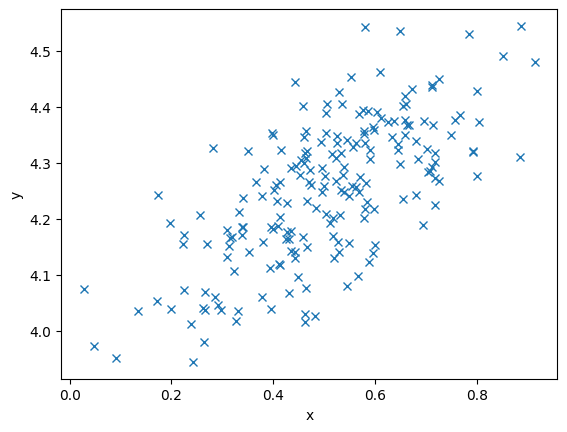

In [6]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 0.1

# x = np.random.rand(100) #100 samples for x between 0 -> 1 
x = np.asarray([np.random.normal(0.5, scale=0.15) for i in range(200)])
x.sort()
y = alpha + beta * x
y = np.random.normal(y, scale=sigma) # for each y value, sample a normal dist centered on that val
fig,ax = plt.subplots()
ax.plot(x,y,'x')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

In [7]:
# MCMC sampling
data = {
    'N' : len(x),
    'x' : x,
    'y' : y
}
posterior = stan.build(stan_code, data=data, random_seed=1)
fit = posterior.sample(num_chains=4,num_samples=1000,num_warmup=500)

Building...

In file included from /Users/echapman/Library/Caches/httpstan/4.9.1/models/shauitn6/model_shauitn6.cpp:2:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /

19 warnings generated.
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/stan_services.o) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/lib/libsundials_nvecserial.a(sundials_math.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/lib/libsundials_idas.a(idaa.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/echapman/Projects/stan-learning/.venv_ls/lib/python3.10/site-packages/httpstan/lib/libsu

In [8]:
az_fit = az.from_pystan(
    posterior=fit, 
    observed_data="y", 
    posterior_predictive="y_hat",
    # predictions="y_pred", 
    posterior_model=posterior)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

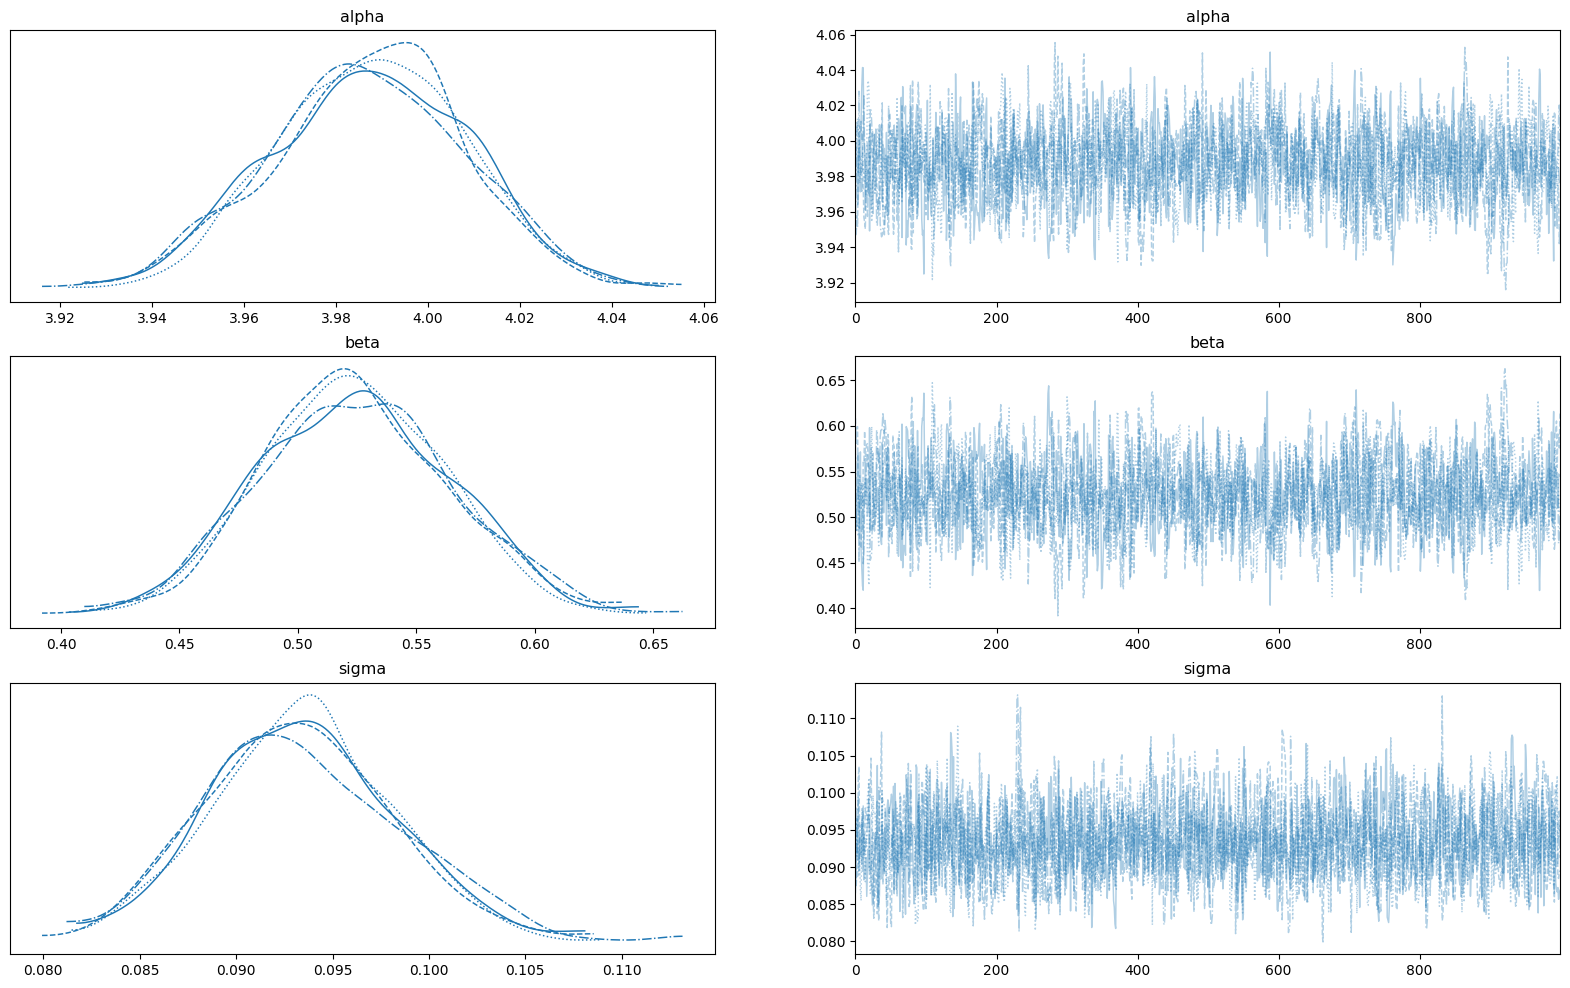

In [9]:
az.plot_trace(az_fit, ['alpha','beta','sigma'], figsize=(20,12))

In [10]:
az_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/ipykernel_3197/3160619395.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


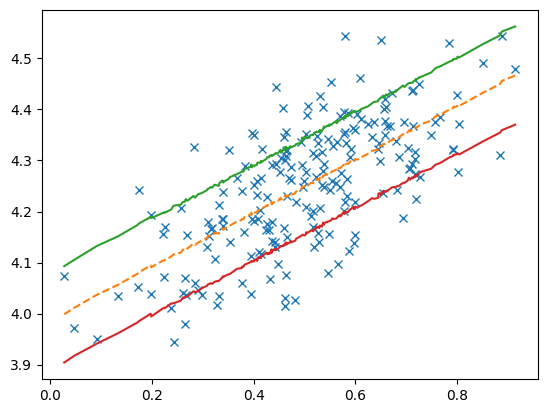

In [11]:
# collapse the chain dimension by listing the chains one after another along dimension 0
y_hat = az_fit['posterior_predictive']['y_hat'].to_numpy().reshape(4000,200)

# find the mean y_hat value at each x point (by averaging across all 4000 samples)
y_hat_bar = y_hat.mean(axis=0)
y_hat_std = y_hat.std(axis=0)

y_hat_upper = y_hat_bar + y_hat_std
y_hat_lower = y_hat_bar - y_hat_std

fig,ax = plt.subplots()
ax.plot(x,y,'x')
ax.plot(x,y_hat_bar,'--')
ax.plot(x,y_hat_upper)
ax.plot(x,y_hat_lower)
fig.show()

# NOTE: Each MCMC sample is conditioned on the full set of observed data, and results in a sampled value for alpha, 
# beta and sigma. A y_hat value is then drawn at each of the x data points using the distribution defined by the sampled
# alpha, beta and sigma values. So we expect the spread of the y_hat draws to be equivalent across all of the x domain! 
# The spread of y_hat was determined at each draw by the sigma value for that sample. And every sigma sample was conditioned
# on the full set of observed data.


<Axes: xlabel='alpha', ylabel='beta'>

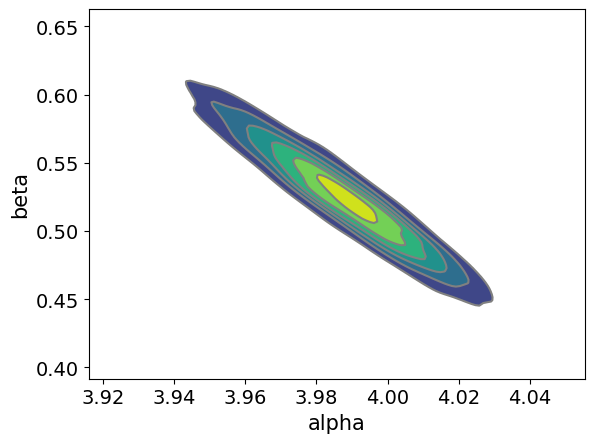

In [13]:
az.plot_pair(az_fit, var_names=["alpha", "beta"], kind="kde")